## Practica 2 - Parte 1
### Perceptron

#### Importar librerías:

In [1]:
import pandas as pd
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import tabulate

/tmp/ipykernel_518311/3283597081.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-04-05 20:09:05.063487: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-05 20:09:05.063691: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-05 20:09:05.066338: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could

#### Dataset:
Cargamos el dataset de iris de la libreria sklearn, al cargar load_iris en iris obtenemos diferentes sets de informacion, guardamos la informacion que nos interesa en un daframe de pandas.

Elimino del dataset los de target = 2 por que solo tenemos que diferenciar entre 2 tipos de iris

In [2]:
iris = datasets.load_iris()
print(iris.DESCR)


.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

:Number of Instances: 150 (50 in each of three classes)
:Number of Attributes: 4 numeric, predictive attributes and the class
:Attribute Information:
    - sepal length in cm
    - sepal width in cm
    - petal length in cm
    - petal width in cm
    - class:
            - Iris-Setosa
            - Iris-Versicolour
            - Iris-Virginica

:Summary Statistics:

============== ==== ==== ======= ===== ====================
                Min  Max   Mean    SD   Class Correlation
============== ==== ==== ======= ===== ====================
sepal length:   4.3  7.9   5.84   0.83    0.7826
sepal width:    2.0  4.4   3.05   0.43   -0.4194
petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
============== ==== ==== ======= ===== ====================

:Missing Attribute Values: None
:Class Distribution: 33.3% for each of 3 classes.
:Cr

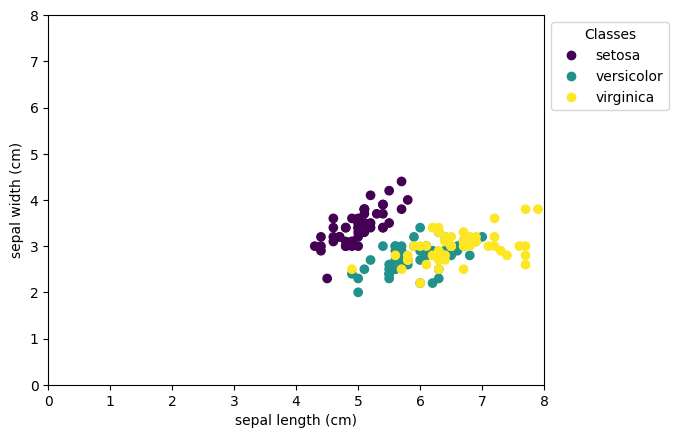

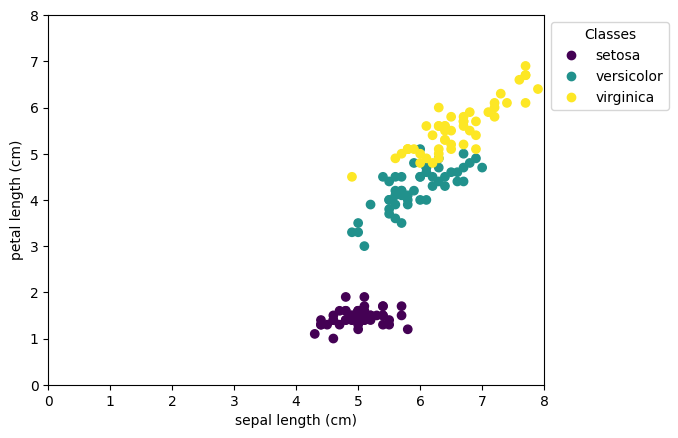

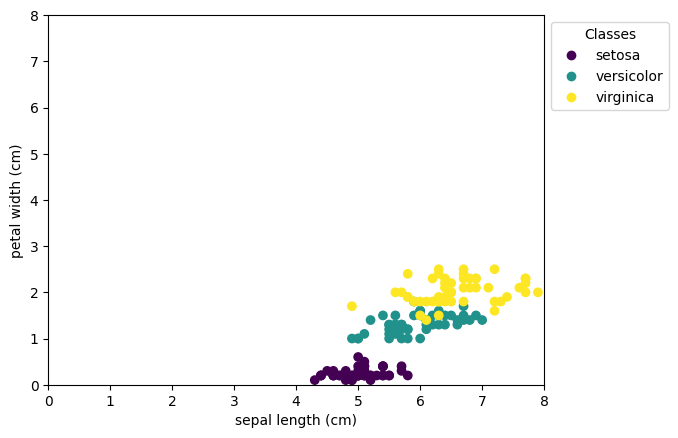

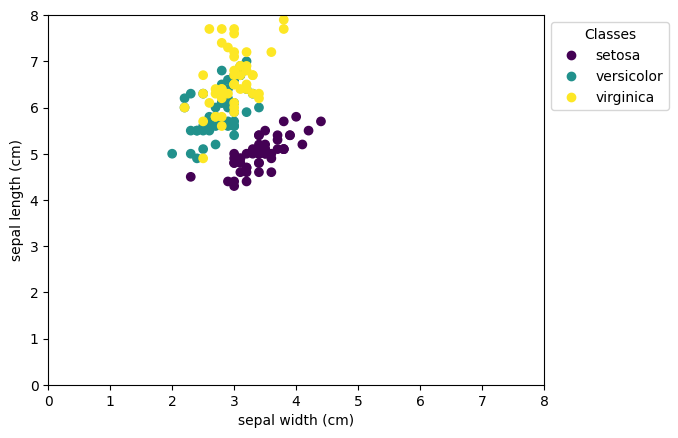

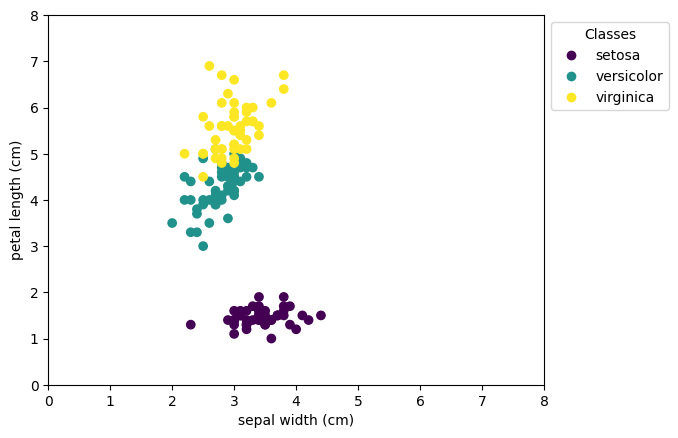

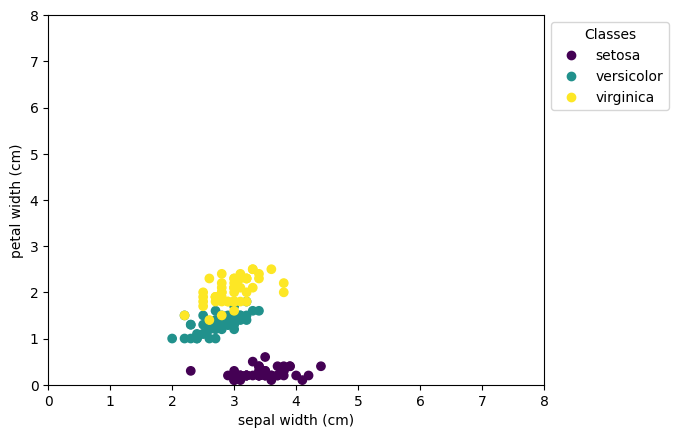

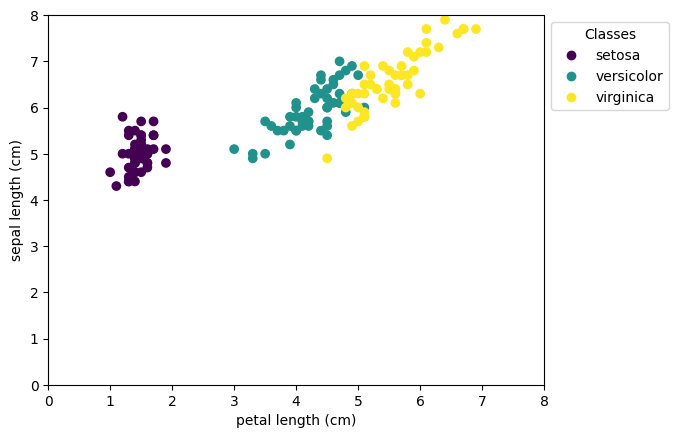

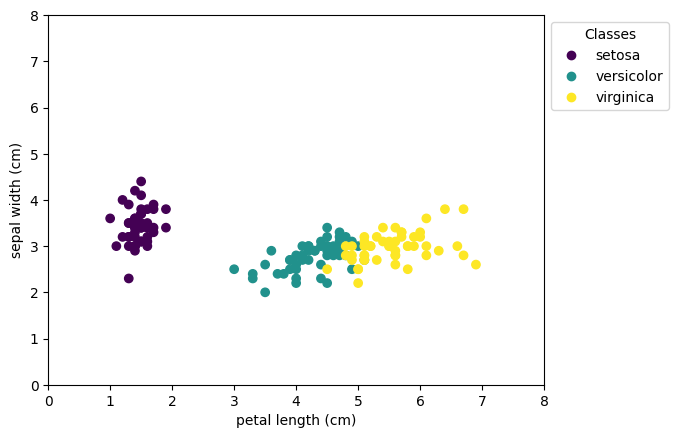

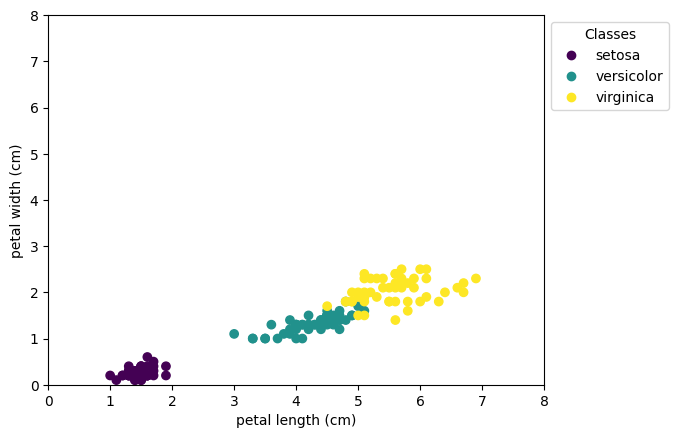

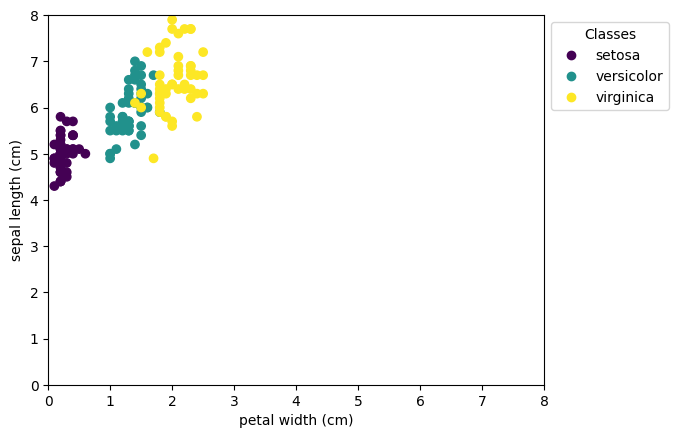

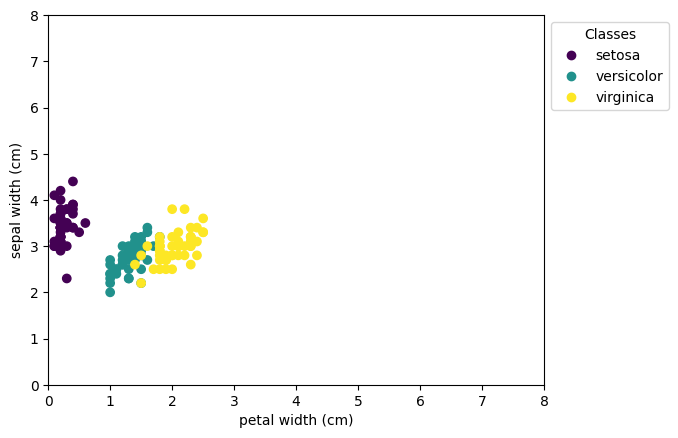

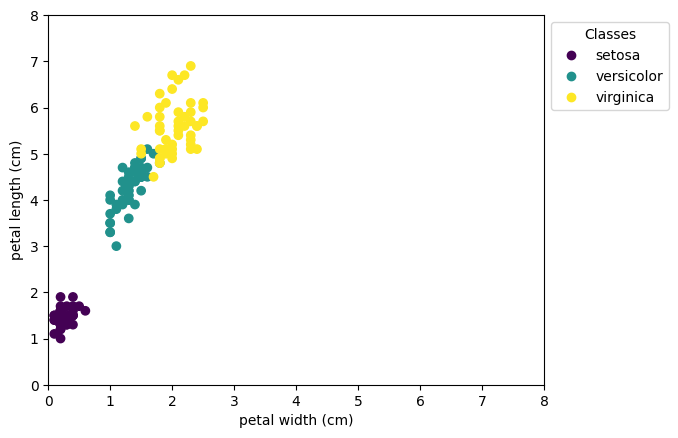

In [3]:
for i in range (0, 4):
    for j in range (0, 4):
        if i == j:
            continue
        _, ax = plt.subplots()
        scatter = ax.scatter(iris.data[:, i], iris.data[:, j], c=iris.target)
        ax.set(xlabel=iris.feature_names[i], ylabel=iris.feature_names[j])
        _ = ax.legend(
            scatter.legend_elements()[0], iris.target_names, loc="upper left", title="Classes", bbox_to_anchor=(1, 1)
        )
        plt.xlim(0, 8)
        plt.ylim(0, 8)


In [4]:

iris_df = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                        columns= iris['feature_names'] + ['target'])
print("Numero de elementos de cada clase")
print(iris_df['target'].value_counts())

iris_df = iris_df.query('target != 2')
# make all target 0 -1 only the target columns
iris_df


Numero de elementos de cada clase
target
0.0    50
1.0    50
2.0    50
Name: count, dtype: int64


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0
...,...,...,...,...,...
95,5.7,3.0,4.2,1.2,1.0
96,5.7,2.9,4.2,1.3,1.0
97,6.2,2.9,4.3,1.3,1.0
98,5.1,2.5,3.0,1.1,1.0


Funcion para nomralizar con L2 las 4 primeras columnas del dataframe

In [5]:
def normalize_l2(df, columns):
  """
  Normalizes specified columns in a dataframe using L2 norm.

  Args:
      df: The pandas dataframe.
      columns: List of column names to normalize.

  Returns:
      A new dataframe with normalized columns.
  """
  df_norm = df.copy()
  for col in columns:
    # Calculate L2 norm for each row
    norm = df[col].apply(lambda x: np.sqrt(sum(x**2 for x in df[col])))

    # Avoid division by zero (rows with all zeros)
    norm[norm == 0] = 1

    # Normalize the column values
    df_norm[col] = df[col] / norm
  return df_norm

# Normalize the first 4 columns
#iris_normalizados = normalize_l2(iris_df.copy(), iris_df.columns[:-1])
iris_normalizados = iris_df.copy()


In [6]:
iris_shuffleados = iris_normalizados.sample(frac=1, random_state=0)

tamañoIris = len(iris_shuffleados)
tamañoTrain = int(tamañoIris * 0.8)


iris_trainAll = iris_shuffleados.iloc[:tamañoTrain]
iris_testAll = iris_shuffleados.iloc[tamañoTrain:]

Setosa = 0


#### Variables para el perceptron:

In [7]:
num_entradas = 2
tasa_aprendizaje = 0.1
umbral = 0
pesosIniciales = tf.Variable(
    tf.random.uniform([2, 1], minval=-1.0, maxval=1.0, dtype=tf.double))

pesosIniciales


<tf.Variable 'Variable:0' shape=(2, 1) dtype=float64, numpy=
array([[-0.5199201 ],
       [ 0.82254897]])>

Nos quedamos con el 80% de los datos para entrenar y el 0% para comprobar

In [8]:
iris_entrenamiento = tf.Variable(iris_trainAll.iloc[:, [0, 3, 4]].values)
iris_test = tf.Variable(iris_testAll.iloc[:, [0, 3, 4]].values)

In [9]:
pesosIniciales
data_list = []

##### Perceptron


In [10]:
class Step:

  def __init__(
          self,
          threshold=0):

    self.__threshold__ = threshold

  def transform(
          self,
          x):

    return 1 if x >= self.__threshold__ else 0


class Perceptron:

  def __init__(
          self,
          activation,
          pesosInicialesIn):

    self.weights = tf.Variable(pesosInicialesIn)
    self.bias = tf.Variable(tf.random.uniform(shape=(1,), dtype=tf.double), dtype=tf.double)

    self.activation = activation

  def predict(self, X):
    X = np.reshape(X, (self.weights.shape[1], self.weights.shape[0]))

    linear_output = tf.add(tf.matmul(X, self.weights), self.bias)
    prediction = self.activation.transform(linear_output)

    return prediction

  def fit(
          self,
          X,
          y,
          epochs=10,
          learning_rate=0.01):

    for epoch in range(1, epochs + 1):

      loss = 0
      learning_rate = tf.cast(learning_rate, tf.double)

      


      for i in range(X.shape[0]):
        
        pesoInicial = self.weights.numpy()

        sample = np.reshape(
            X[i], (self.weights.shape[0], self.weights.shape[1]))

        prediction = self.predict(sample)

        error = y[i] - prediction
        loss += abs(error)

        # Compute deltas
        dweights = learning_rate * error * sample
        dbias = tf.cast(learning_rate * error, tf.double)
        dbias = tf.reshape(dbias, [1])

        self.weights.assign_add(dweights)
        self.bias.assign_add(dbias)
        if i == X.shape[0]-1:
          print("\n\nweights: "+ str(self.weights.numpy()) + "\n bias: " + str(self.bias.numpy()))

          data = {
            "Learning rate": "{:.2e}".format(learning_rate.numpy()),
            "epoch": epoch,
            "entradas": X[i].numpy(),
            "pesos": ["{:.2e}".format(pesosIniciales.numpy()[0][0]), "{:.2e}".format(pesosIniciales.numpy()[1][0])],
            "prediction": prediction,
            "Salida deseada": "{:.2e}".format(y[i].numpy()),
            "loss": "{:.2e}".format(loss),
            "Pesos finales": ["{:.2e}".format(self.weights.numpy()[0][0]), "{:.2e}".format(self.weights.numpy()[1][0])],
            "bias": "{:.2e}".format(self.bias.numpy()[0]),
          }
          data_list.append(data)

      loss /= X.shape[0]
      if loss == 0:
          print(f"Training completed with zero error at epoch {epoch}")
          break

      if (epoch % 1) == 0 or (epoch == epochs - 1):
        print(f"Epoch {epoch} with loss {loss}")

##### Comprobar resultados 

In [11]:
datos_entrenamiento = iris_entrenamiento[:, :-1]
target_entrenamiento = iris_entrenamiento[:, -1]
epochs = 300

datos_test = iris_test[:, :-1]
indices_test = iris_test[:, -1]

# Lista de learning rates
learning_rate = 0.01


print(f"\n Learning rate: {learning_rate}")
perceptron = Perceptron(Step(umbral), pesosIniciales)
perceptron.fit(datos_entrenamiento, target_entrenamiento, epochs, learning_rate=learning_rate)



 Learning rate: 0.01




weights: [[-0.3159201 ]
 [ 0.87154897]]
 bias: [1.02242671]
Epoch 1 with loss 0.0625


weights: [[-0.3019201 ]
 [ 0.87954897]]
 bias: [1.02242671]
Epoch 2 with loss 0.025


weights: [[-0.2919201 ]
 [ 0.88354897]]
 bias: [1.02242671]
Epoch 3 with loss 0.025


weights: [[-0.3079201 ]
 [ 0.89354897]]
 bias: [1.01242671]
Epoch 4 with loss 0.0625


weights: [[-0.2979201 ]
 [ 0.89754897]]
 bias: [1.01242671]
Epoch 5 with loss 0.025


weights: [[-0.2879201 ]
 [ 0.90154897]]
 bias: [1.01242671]
Epoch 6 with loss 0.025


weights: [[-0.3049201 ]
 [ 0.91154897]]
 bias: [1.00242671]
Epoch 7 with loss 0.0625


weights: [[-0.2949201 ]
 [ 0.91554897]]
 bias: [1.00242671]
Epoch 8 with loss 0.025


weights: [[-0.2789201 ]
 [ 0.92454897]]
 bias: [1.00242671]
Epoch 9 with loss 0.05


weights: [[-0.3149201 ]
 [ 0.92554897]]
 bias: [0.99242671]
Epoch 10 with loss 0.0375


weights: [[-0.3149201 ]
 [ 0.92554897]]
 bias: [0.99242671]
Training completed with zero error at epoch 11


In [12]:
for i in range(datos_test.shape[0]):
  sample = datos_test[i]
  prediction = perceptron.predict(sample)
  print(f"Sample {sample} with prediction {prediction} and target {indices_test[i]}")

Sample [5.  0.2] with prediction 0 and target 0.0
Sample [4.9 0.1] with prediction 0 and target 0.0
Sample [5.5 1. ] with prediction 1 and target 1.0
Sample [5.1 0.2] with prediction 0 and target 0.0
Sample [5.1 0.2] with prediction 0 and target 0.0
Sample [6.7 1.4] with prediction 1 and target 1.0
Sample [6.6 1.3] with prediction 1 and target 1.0
Sample [4.8 0.1] with prediction 0 and target 0.0
Sample [5.6 1.3] with prediction 1 and target 1.0
Sample [5.9 1.8] with prediction 1 and target 1.0
Sample [6.3 1.3] with prediction 1 and target 1.0
Sample [5.5 0.2] with prediction 0 and target 0.0
Sample [5.1 0.4] with prediction 0 and target 0.0
Sample [6.  1.6] with prediction 1 and target 1.0
Sample [4.9 0.1] with prediction 0 and target 0.0
Sample [5.7 1.3] with prediction 1 and target 1.0
Sample [5.8 1. ] with prediction 1 and target 1.0
Sample [5.6 1.3] with prediction 1 and target 1.0
Sample [4.6 0.2] with prediction 0 and target 0.0
Sample [5.1 0.4] with prediction 0 and target 0.0


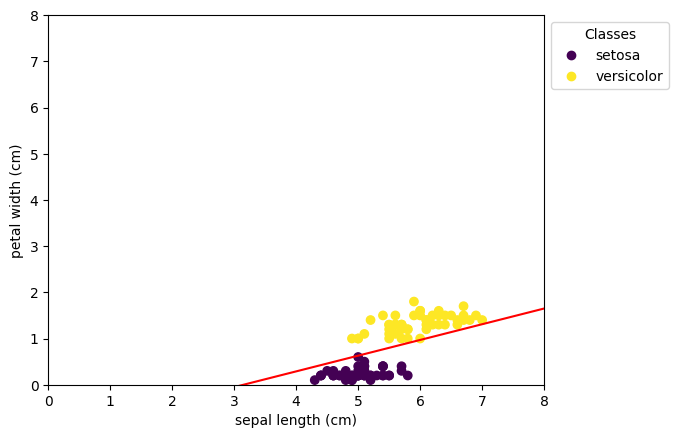

In [13]:
w = perceptron.weights
b = perceptron.bias
_, ax = plt.subplots()
scatter = ax.scatter(iris_shuffleados.iloc[:, 0], iris_shuffleados.iloc[:, 3], c=iris_shuffleados.iloc[:, 4])
ax.set(xlabel=iris.feature_names[0], ylabel=iris.feature_names[3])
_ = ax.legend(
    scatter.legend_elements()[0], iris.target_names, loc="upper left", title="Classes", bbox_to_anchor=(1, 1)
)
plt.xlim(0, 8)
plt.ylim(0, 8)

x_min, x_max = ax.get_xlim()

x = np.linspace(x_min, x_max, 100)
y = (-b - w[0] * x) / w[1]
plt.plot(x, y, '-r')
plt.show()


In [14]:
df = pd.DataFrame(data_list)
# Save the DataFrame to a CSV file
df.to_csv("training_data.csv", index=False)

print("Data saved to training_data.csv")

Data saved to training_data.csv


#### Perceptron 3 entradas


In [15]:
pesosIniciales3 = tf.Variable(
        tf.random.normal([3, 1], dtype=tf.double))

iris_entrenamiento = tf.Variable(iris_trainAll.iloc[:, [0,1, 2, 4]].values)
iris_test = tf.Variable(iris_testAll.iloc[:, [0,1, 2, 4]].values)

In [16]:
datos_entrenamiento = iris_entrenamiento[:, :-1]
target_entrenamiento = iris_entrenamiento[:, -1]
epochs = 300

datos_test = iris_test[:, :-1]
indices_test = iris_test[:, -1]

# Lista de learning rates
learning_rates = [0.01, 0.05, 0.1, 0.5, 1.0]

learning_rate = 0.1
perceptron = Perceptron(Step(umbral), pesosIniciales3)
perceptron.fit(datos_entrenamiento, target_entrenamiento, epochs, learning_rate=learning_rate)



weights: [[-0.68214546]
 [-1.00426027]
 [ 1.68662214]]
 bias: [0.65768207]
Epoch 1 with loss 0.0625


weights: [[-0.71214546]
 [-1.09426027]
 [ 1.81662214]]
 bias: [0.65768207]
Epoch 2 with loss 0.025


weights: [[-0.74214546]
 [-1.18426028]
 [ 1.94662215]]
 bias: [0.65768207]
Epoch 3 with loss 0.025


weights: [[-0.77214546]
 [-1.27426028]
 [ 2.07662215]]
 bias: [0.65768207]
Epoch 4 with loss 0.025


weights: [[-0.26214545]
 [-1.02426027]
 [ 2.37662215]]
 bias: [0.75768207]
Epoch 5 with loss 0.0125


weights: [[-0.74214546]
 [-1.33426028]
 [ 2.21662215]]
 bias: [0.65768207]
Epoch 6 with loss 0.0125


weights: [[-0.74214546]
 [-1.33426028]
 [ 2.21662215]]
 bias: [0.65768207]
Training completed with zero error at epoch 7


In [17]:
for i in range(datos_test.shape[0]):
  sample = datos_test[i]
  prediction = perceptron.predict(sample)
  print(f"Sample {sample} with prediction {prediction} and target {indices_test[i]}")

Sample [5.  3.  1.6] with prediction 0 and target 0.0
Sample [4.9 3.6 1.4] with prediction 0 and target 0.0
Sample [5.5 2.4 3.7] with prediction 1 and target 1.0
Sample [5.1 3.8 1.6] with prediction 0 and target 0.0
Sample [5.1 3.4 1.5] with prediction 0 and target 0.0
Sample [6.7 3.1 4.4] with prediction 1 and target 1.0
Sample [6.6 2.9 4.6] with prediction 1 and target 1.0
Sample [4.8 3.  1.4] with prediction 0 and target 0.0
Sample [5.6 3.  4.1] with prediction 1 and target 1.0
Sample [5.9 3.2 4.8] with prediction 1 and target 1.0
Sample [6.3 2.3 4.4] with prediction 1 and target 1.0
Sample [5.5 3.5 1.3] with prediction 0 and target 0.0
Sample [5.1 3.7 1.5] with prediction 0 and target 0.0
Sample [6.  2.7 5.1] with prediction 1 and target 1.0
Sample [4.9 3.1 1.5] with prediction 0 and target 0.0
Sample [5.7 2.9 4.2] with prediction 1 and target 1.0
Sample [5.8 2.7 4.1] with prediction 1 and target 1.0
Sample [5.6 2.9 3.6] with prediction 1 and target 1.0
Sample [4.6 3.2 1.4] with pr

In [18]:
# plot the data in a 3d plot:
#w = perceptron.weights
#b = perceptron.bias
#fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
#scatter = ax.scatter(iris_shuffleados.iloc[:, 0], iris_shuffleados.iloc[:, 1], iris_shuffleados.iloc[:, 2], c=iris_shuffleados.iloc[:, 4])
#ax.set(xlabel=iris.feature_names[0], ylabel=iris.feature_names[1], zlabel=iris.feature_names[2])
#_ = ax.legend(
#    scatter.legend_elements()[0], iris.target_names, loc="upper left", title="Classes", bbox_to_anchor=(1, 1)
#)
#plt.xlim(0, 8)
#plt.ylim(0, 8)
#
## Assuming you have perceptron weights (w) and bias (b)
#x = np.linspace(0, 8, 100)
#y = np.linspace(0, 8, 100)
#x, y = np.meshgrid(x, y)
#z = (-b - w[0].numpy()[0] * x - w[1].numpy()[0] * y) / w[2].numpy()[0]
#
#
## Plot the decision plane
#ax.plot_surface(x, y, z, alpha=0.5)
#
#ax.view_init(elev=15, azim=-20)  # 15: elevation, -60: azimuth for left rotation
## Add title and show the plot
#ax.set_title('Iris Dataset - 3D Scatter Plot with Decision Plane')
#plt.show()


#### Perceptron todas las entradas

In [19]:
pesosIniciales4 = tf.Variable(
        tf.random.normal([4, 1], dtype=tf.double))

iris_entrenamiento = tf.Variable(iris_trainAll)
iris_test = tf.Variable(iris_testAll)

In [20]:
datos_entrenamiento = iris_entrenamiento[:, :-1]
target_entrenamiento = iris_entrenamiento[:, -1]
epochs = 50

datos_test = iris_test[:, :-1]
indices_test = iris_test[:, -1]

# Lista de learning rates
learning_rates = [0.01, 0.05, 0.1, 0.5, 1.0]

learning_rate = 0.1
perceptron = Perceptron(Step(umbral), pesosIniciales4)
perceptron.fit(datos_entrenamiento, target_entrenamiento, epochs, learning_rate=learning_rate)



weights: [[ 0.37635739]
 [-0.98394727]
 [-0.17552437]
 [ 2.167752  ]]
 bias: [0.17727622]
Epoch 1 with loss 0.2375


weights: [[ 0.24635739]
 [-1.28394728]
 [ 0.32447564]
 [ 2.37775201]]
 bias: [0.07727622]
Epoch 2 with loss 0.0625


weights: [[ 0.24635739]
 [-1.28394728]
 [ 0.32447564]
 [ 2.37775201]]
 bias: [0.07727622]
Training completed with zero error at epoch 3


In [21]:
for i in range(datos_test.shape[0]):
  sample = datos_test[i]
  prediction = perceptron.predict(sample)
  print(f"Sample {sample} with prediction {prediction} and target {indices_test[i]}")

Sample [5.  3.  1.6 0.2] with prediction 0 and target 0.0
Sample [4.9 3.6 1.4 0.1] with prediction 0 and target 0.0
Sample [5.5 2.4 3.7 1. ] with prediction 1 and target 1.0
Sample [5.1 3.8 1.6 0.2] with prediction 0 and target 0.0
Sample [5.1 3.4 1.5 0.2] with prediction 0 and target 0.0
Sample [6.7 3.1 4.4 1.4] with prediction 1 and target 1.0
Sample [6.6 2.9 4.6 1.3] with prediction 1 and target 1.0
Sample [4.8 3.  1.4 0.1] with prediction 0 and target 0.0
Sample [5.6 3.  4.1 1.3] with prediction 1 and target 1.0
Sample [5.9 3.2 4.8 1.8] with prediction 1 and target 1.0
Sample [6.3 2.3 4.4 1.3] with prediction 1 and target 1.0
Sample [5.5 3.5 1.3 0.2] with prediction 0 and target 0.0
Sample [5.1 3.7 1.5 0.4] with prediction 0 and target 0.0
Sample [6.  2.7 5.1 1.6] with prediction 1 and target 1.0
Sample [4.9 3.1 1.5 0.1] with prediction 0 and target 0.0
Sample [5.7 2.9 4.2 1.3] with prediction 1 and target 1.0
Sample [5.8 2.7 4.1 1. ] with prediction 1 and target 1.0
Sample [5.6 2.

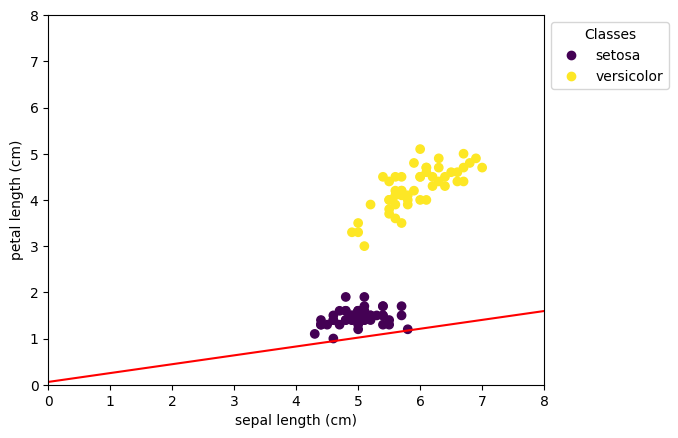

In [22]:
b = perceptron.bias
w = perceptron.weights
_, ax = plt.subplots()
scatter = ax.scatter(iris_shuffleados.iloc[:, 0], iris_shuffleados.iloc[:, 2], c=iris_shuffleados.iloc[:, 4])
ax.set(xlabel=iris.feature_names[0], ylabel=iris.feature_names[2])
_ = ax.legend(
    scatter.legend_elements()[0], iris.target_names, loc="upper left", title="Classes", bbox_to_anchor=(1, 1)
)
plt.xlim(0, 8)
plt.ylim(0, 8)
x = np.linspace(0, 8, 100)
y = (-b - w[0] * x) / w[1]
plt.plot(x, y, '-r')
plt.show()
